In [1]:
# import libraries
import json
import csv
import pandas as pd
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# the following code ensures that you can see your (print) results for multiple tasks within a coding block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

2023-07-23 09:12:44.508314: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 09:12:45.276104: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
pip install wordcloud

  Using cached wordcloud-1.9.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (460 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
def convert_json_to_df(file_path):
    # Open the json file and load it as a dictionary
    with open(file_path, "r") as f:
        dic = json.load(f)
    
    # Intialize our columns
    text = []
    hypothesis = []
    label = []
    
    # Iterate through documents and their labels and hypothesis
    for doc in dic["documents"]:
        for nda in doc["annotation_sets"][0]['annotations']:
            # Add the text to the text column
            text.append(doc["text"])
            # Add the label to label column
            label.append(doc["annotation_sets"][0]['annotations'][nda]["choice"])
            # Add the hypothesis to hypothesis column
            hypothesis.append(dic["labels"][nda]["hypothesis"])
            
    # Create a data frame with the previous columns
    df = pd.DataFrame({"text": text, "hypothesis": hypothesis, "label": label})
    
    return df

In [3]:
train = convert_json_to_df("train.json")

In [4]:
train.head()
train.shape

,text,hypothesis,label
0,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,NotMentioned
1,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall destroy or return some C...,Entailment
2,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Agreement shall not grant Receiving Party any ...,Entailment
3,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not disclose the fact th...,Entailment
4,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Confidential Information shall only include te...,NotMentioned


(7191, 3)

In [5]:
test = convert_json_to_df("test.json")

In [6]:
test.head()
test.shape

,text,hypothesis,label
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction


(2091, 3)

In [7]:
valid = convert_json_to_df("dev.json")

In [8]:
valid.head()
valid.shape

,text,hypothesis,label
0,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not reverse engineer any...,Entailment
1,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall destroy or return some C...,Entailment
2,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Agreement shall not grant Receiving Party any ...,Entailment
3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not disclose the fact th...,Entailment
4,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Confidential Information shall only include te...,Contradiction


(1037, 3)

In [9]:
# define a function to calculate number of words for text column
def count_words(text):
    return len(str(text).split())

,text,hypothesis,label,word_counts
count,7191,7191,7191,7191.000000
unique,423,17,3,NaN
top,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,Entailment,NaN
freq,17,423,3530,NaN
mean,NaN,NaN,NaN,1673.631206
std,NaN,NaN,NaN,1029.016036
min,NaN,NaN,NaN,211.000000
25%,NaN,NaN,NaN,940.000000
50%,NaN,NaN,NaN,1504.000000
75%,NaN,NaN,NaN,2063.000000


(array([2176., 2805., 1190.,  561.,  306.,   85.,   34.,   17.,    0.,
          17.]),
 array([ 211. , 1032.7, 1854.4, 2676.1, 3497.8, 4319.5, 5141.2, 5962.9,
        6784.6, 7606.3, 8428. ]),
 <BarContainer object of 10 artists>)

(array([2820.,    0.,    0.,    0.,    0., 3530.,    0.,    0.,    0.,
         841.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

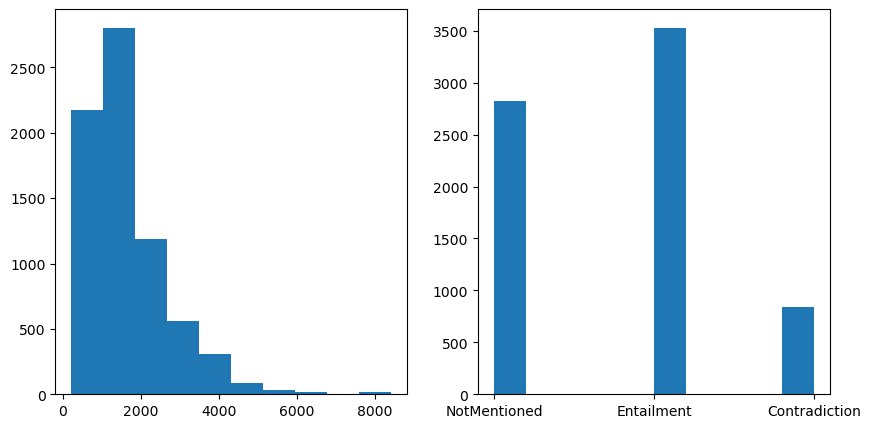

In [10]:
# calculate the words in each record in text column
train["word_counts"] = train["text"].apply(count_words)
# print some statistics for the train data
train.describe(include = 'all')
# plot the distribution for the words count and label
fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(10, 5))
plot1.hist(train["word_counts"])
plot2.hist(train["label"])

,text,hypothesis,label,word_counts
count,2091,2091,2091,2091.000000
unique,122,17,3,NaN
top,DEPARTMENT OF HOMELAND SECURITY\nNON-DISCLOSUR...,Receiving Party shall not reverse engineer any...,Entailment,NaN
freq,34,123,968,NaN
mean,NaN,NaN,NaN,1708.821138
std,NaN,NaN,NaN,1111.083966
min,NaN,NaN,NaN,205.000000
25%,NaN,NaN,NaN,924.000000
50%,NaN,NaN,NaN,1417.000000
75%,NaN,NaN,NaN,2214.000000


(array([374., 680., 459., 255., 102., 136.,  34.,   0.,  17.,  34.]),
 array([ 205. ,  811.2, 1417.4, 2023.6, 2629.8, 3236. , 3842.2, 4448.4,
        5054.6, 5660.8, 6267. ]),
 <BarContainer object of 10 artists>)

(array([903.,   0.,   0.,   0.,   0., 968.,   0.,   0.,   0., 220.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

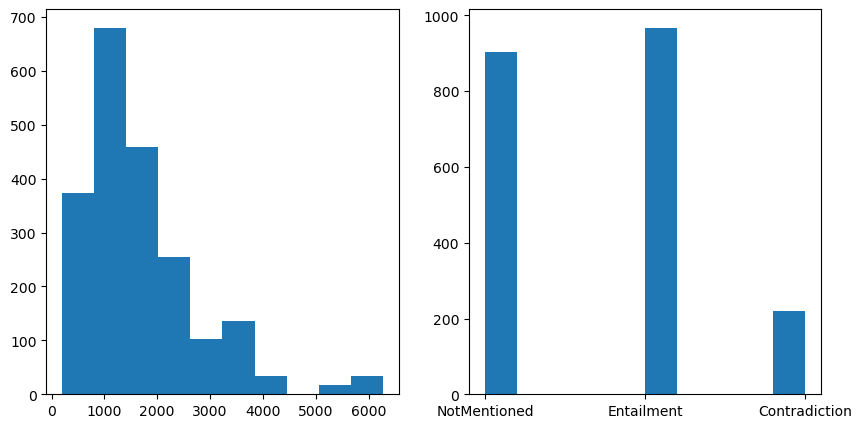

In [14]:
# calculate the words in each record in text column
test["word_counts"] = test["text"].apply(count_words)
# print some statistics for the train data
test.describe(include = 'all')
# plot the distribution for the words count and label
fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(10, 5))
plot1.hist(test["word_counts"])
plot2.hist(test["label"])

,text,hypothesis,label,word_counts
count,1037,1037,1037,1037.000000
unique,61,17,3,NaN
top,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not reverse engineer any...,Entailment,NaN
freq,17,61,519,NaN
mean,NaN,NaN,NaN,1823.836066
std,NaN,NaN,NaN,1004.583793
min,NaN,NaN,NaN,342.000000
25%,NaN,NaN,NaN,1055.000000
50%,NaN,NaN,NaN,1727.000000
75%,NaN,NaN,NaN,2281.000000


(array([ 85., 340.,  68., 255., 119.,  34.,  34.,  51.,  17.,  34.]),
 array([ 342. ,  787.4, 1232.8, 1678.2, 2123.6, 2569. , 3014.4, 3459.8,
        3905.2, 4350.6, 4796. ]),
 <BarContainer object of 10 artists>)

(array([519.,   0.,   0.,   0.,   0.,  95.,   0.,   0.,   0., 423.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

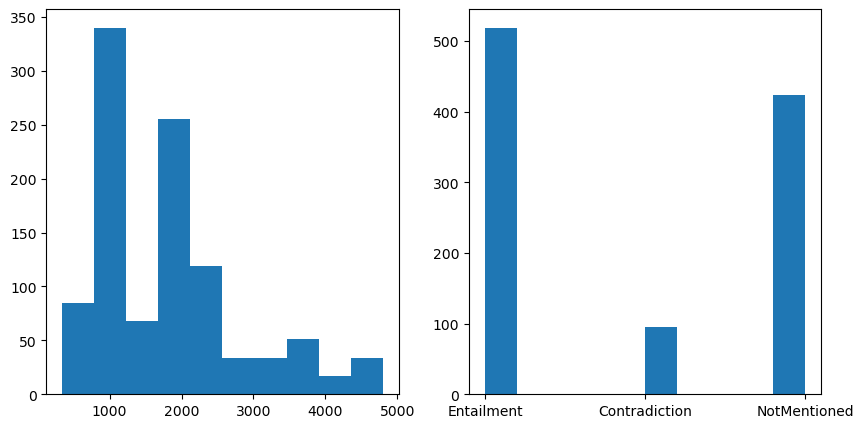

In [15]:
# calculate the words in each record in text column
valid["word_counts"] = valid["text"].apply(count_words)
# print some statistics for the train data
valid.describe(include = 'all')
# plot the distribution for the words count and label
fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(10, 5))
plot1.hist(valid["word_counts"])
plot2.hist(valid["label"])

<Figure size 1000x600 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud of Text Column in dev')

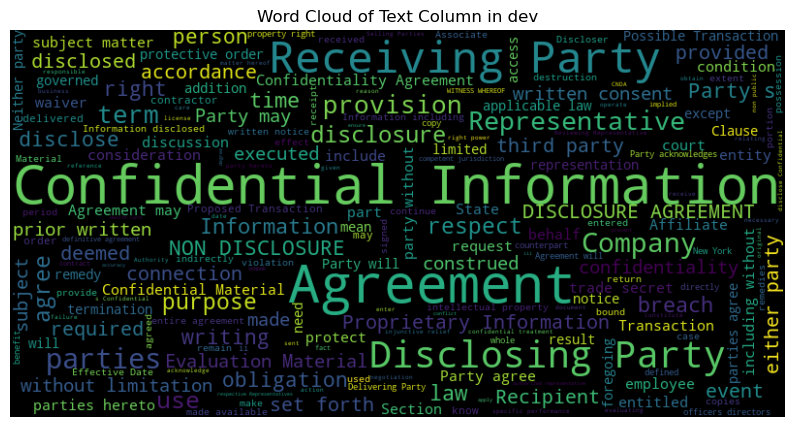

In [21]:
from wordcloud import WordCloud

text_data = ' '.join(valid['text'])
wordcloud = WordCloud(width=800, height=400).generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Column in dev')
plt.show()

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Label Distribution in train')

Text(0.5, 0, 'Label')

Text(0, 0.5, 'Count')

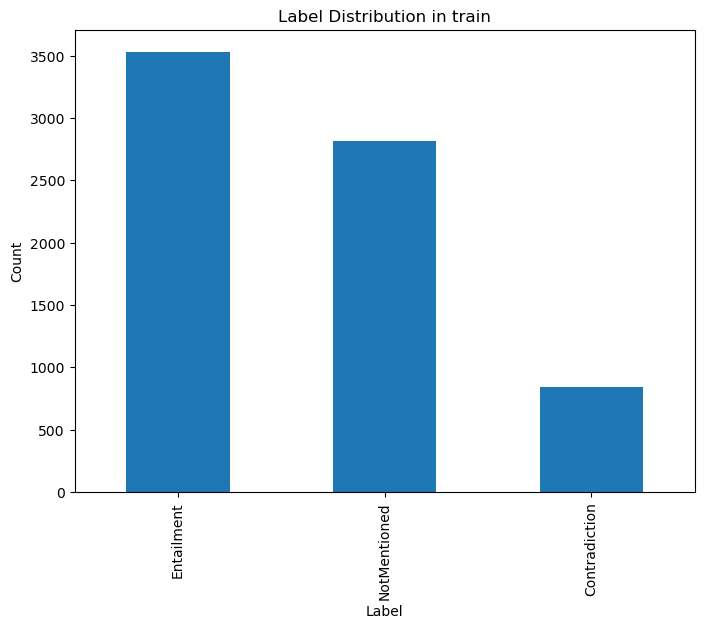

<Figure size 800x600 with 0 Axes>

(array([1269.,    0.,  846.,  846.,  423.,  423.,  846.,  423.,    0.,
         423.,    0.,  846.,    0.,    0.,    0.,  423.,    0.,    0.,
           0.,  423.]),
 array([ 66. ,  70.8,  75.6,  80.4,  85.2,  90. ,  94.8,  99.6, 104.4,
        109.2, 114. , 118.8, 123.6, 128.4, 133.2, 138. , 142.8, 147.6,
        152.4, 157.2, 162. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Hypothesis Lengths in train')

Text(0.5, 0, 'Length')

Text(0, 0.5, 'Frequency')

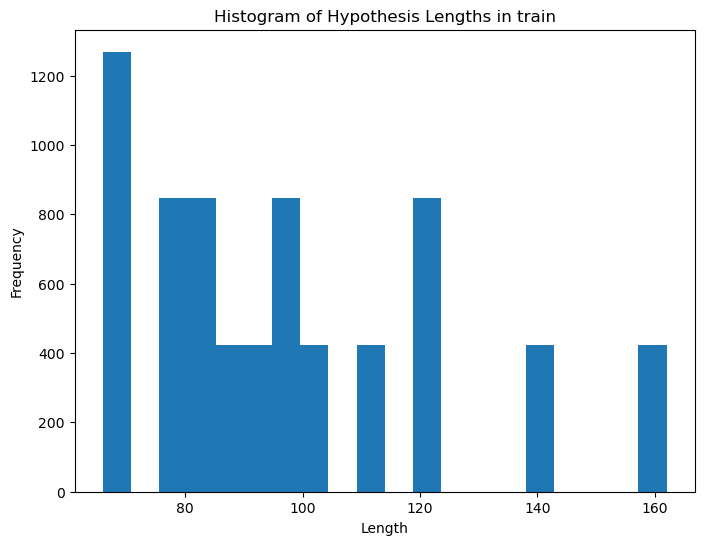

<Figure size 1000x600 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud of Text Column in train')

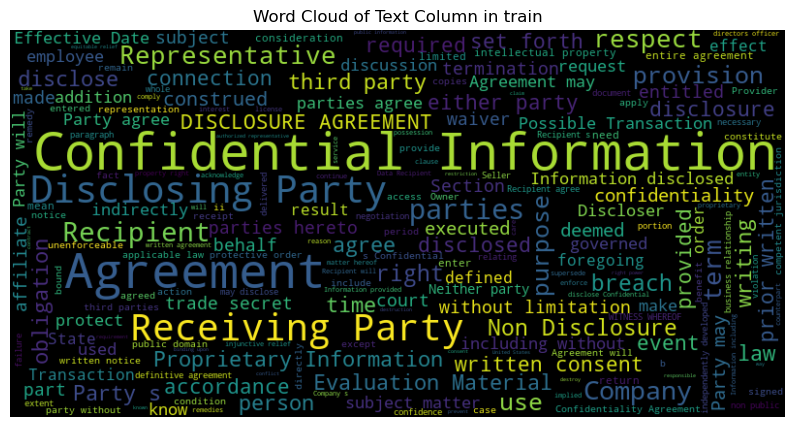

In [20]:
plt.figure(figsize=(8, 6))
train['label'].value_counts().plot(kind='bar')
plt.title("Label Distribution in train")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

train['hypothesis_length'] = train['hypothesis'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(train['hypothesis_length'], bins=20)
plt.title("Histogram of Hypothesis Lengths in train")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

text_data_train = ' '.join(train['text'])
wordcloud_train = WordCloud(width=800, height=400).generate(text_data_train)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_train, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Column in train')
plt.show()

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Label Distribution in test')

Text(0.5, 0, 'Label')

Text(0, 0.5, 'Count')

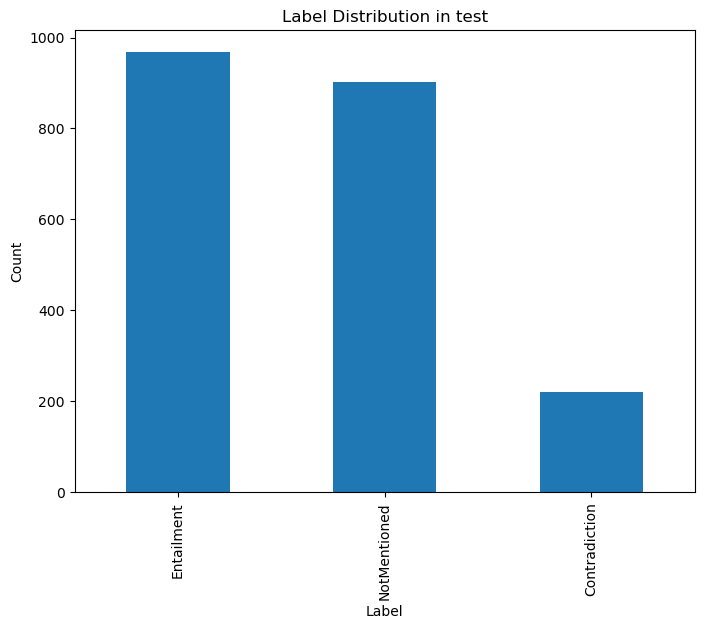

<Figure size 800x600 with 0 Axes>

(array([369.,   0., 246., 246., 123., 123., 246., 123.,   0., 123.,   0.,
        246.,   0.,   0.,   0., 123.,   0.,   0.,   0., 123.]),
 array([ 66. ,  70.8,  75.6,  80.4,  85.2,  90. ,  94.8,  99.6, 104.4,
        109.2, 114. , 118.8, 123.6, 128.4, 133.2, 138. , 142.8, 147.6,
        152.4, 157.2, 162. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Hypothesis Lengths in test')

Text(0.5, 0, 'Length')

Text(0, 0.5, 'Frequency')

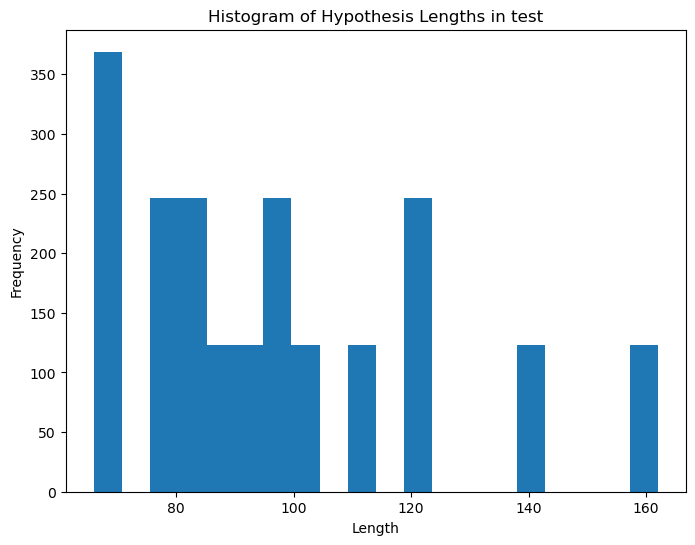

<Figure size 1000x600 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

Text(0.5, 1.0, 'Word Cloud of Text Column in train')

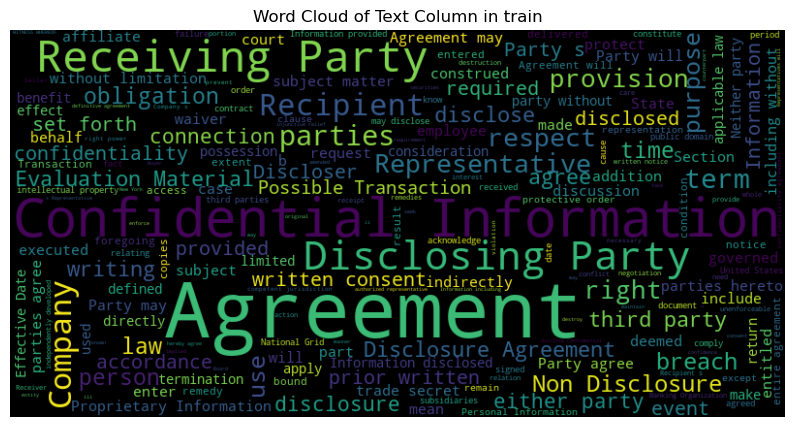

In [22]:
plt.figure(figsize=(8, 6))
test['label'].value_counts().plot(kind='bar')
plt.title("Label Distribution in test")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

test['hypothesis_length'] = test['hypothesis'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(test['hypothesis_length'], bins=20)
plt.title("Histogram of Hypothesis Lengths in test")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

text_data_train = ' '.join(test['text'])
wordcloud_train = WordCloud(width=800, height=400).generate(text_data_train)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_train, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Column in train')
plt.show()

The dataset consists of three subsets: the train dataset, the test dataset, and the dev dataset. Here is a summary of the statistics for each dataset:

1. Train Dataset:

- Number of Documents: 7,191
- Mean Document Length: 11,049.29
- Minimum Document Length: 1,481
- Maximum Document Length: 54,571
- Median Document Length: 9,936.0
2. Test Dataset:

- Number of Documents: 2,091
- Mean Document Length: 11,218.21
- Minimum Document Length: 1,231
- Maximum Document Length: 41,779
- Median Document Length: 9,614.0
3. Dev Dataset:

- Number of Documents: 1,037
- Mean Document Length: 12,094.97
- Minimum Document Length: 2,270
- Maximum Document Length: 32,359
- Median Document Length: 11,299.0

### Q2
Two state-of-the-art (SOTA) transformer-based models for the Natural Language Inference (NLI) task, I will select the following models:


1. RoBERTa is a language model based on the transformer architecture, an extension of BERT. It was introduced by Facebook AI and is designed to learn better language representations by employing a more extensive training process than BERT. RoBERTa removes the next sentence prediction task and utilizes larger batch sizes and more training data. This approach results in improved performance and robustness. RoBERTa achieves state-of-the-art results on various natural language understanding tasks and is widely used in NLP applications. It is available in the Hugging Face Transformers library in different pre-trained variants.

2. DistilBERT is a smaller and faster version of the BERT model that maintains similar performance by using knowledge distillation from the original BERT model. It has fewer layers and parameters, making it more memory-efficient and suitable for deployment on devices with limited resources or in real-time processing scenarios. DistilBERT has been widely used in various NLP tasks and is available in the Hugging Face Transformers library as a pre-trained model for natural language understanding tasks.


## 1-Roberta model

In [10]:
# upload roberta model and tokenizer
model_name_1 = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name_1)

In [11]:
# tokenization function to tokenize text and hypothesis column
def tokenize_data(data):
    return tokenizer(text=data['text'].tolist(), text_pair=data['hypothesis'].tolist(), truncation=True, padding="max_length", max_length=512)

In [12]:
# customized data loader
class Data_Loader(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        # Here we ensure the label is an integer tensor
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

In [13]:
# encode the label for each data
label_mapping = {"NotMentioned": 0, "Entailment": 1, "Contradiction": 2}

train_labels = [label_mapping[label] for label in train['label'].tolist()]
valid_labels = [label_mapping[label] for label in valid['label'].tolist()]
test_labels = [label_mapping[label] for label in test['label'].tolist()]

# tokenize hypothesis column and text column
train_encodings = tokenize_data(train)
valid_encodings = tokenize_data(valid)
test_encodings = tokenize_data(test)

In [14]:
# perform data loader on each data set
train_dataset = Data_Loader(train_encodings, train_labels)
valid_dataset = Data_Loader(valid_encodings, valid_labels)
testing_dataset = Data_Loader(test_encodings, test_labels)

In [15]:
# define the model
model_1 = AutoModelForSequenceClassification.from_pretrained(model_name_1, num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# sets up a configuration for training
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=18,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

In [40]:
# function to compute the metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    accuracy = (preds == p.label_ids).mean()
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model_1,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.763400,0.728863,0.686596,0.694740,0.686596,0.689528
2,0.691900,0.671553,0.702025,0.708245,0.702025,0.700969
3,0.650300,0.636152,0.718419,0.723532,0.718419,0.720327


TrainOutput(global_step=1350, training_loss=0.7267602581448025, metrics={'train_runtime': 681.4036, 'train_samples_per_second': 31.66, 'train_steps_per_second': 1.981, 'total_flos': 5676145760646144.0, 'train_loss': 0.7267602581448025, 'epoch': 3.0})

In [41]:
# perform prediction on the test data
pred_1 = trainer.predict(testing_dataset)
print(pred_1.predictions.shape, pred_1.label_ids.shape)

(2091, 3) (2091,)


In [54]:
# calculate the metrics
preds_1 = np.argmax(pred_1.predictions, axis=-1)

precision, recall, f1, _ = precision_recall_fscore_support(y_true=pred_1.label_ids, y_pred=preds_1, average='weighted')
accuracy = evaluate.load("accuracy").compute(predictions=preds_1, references=pred_1.label_ids)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Accuracy: {'accuracy': 0.7054041128646581}
Precision: 0.706616262581651
Recall: 0.7054041128646581
F1 score: 0.7052882116208365


Overall, the model's performance improves with each epoch, as evidenced by decreasing losses and increasing accuracy, precision, recall, and F1 score. 
the model shows decent performance with an accuracy, precision, recall, and F1 score all around 70%.

Overall, the model's performance improves with each epoch, as evidenced by decreasing losses and increasing accuracy, precision, recall, and F1 score.## 2-DistilBERT model

## 2-DistilBERT Model

In [18]:
model_name_2 = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name_2)

In [19]:
def tokenize_data(data):
    return tokenizer(text=data['text'].tolist(), text_pair=data['hypothesis'].tolist(), truncation=True, padding="max_length", max_length=512)

In [20]:
# encode the label for each data
label_mapping = {"NotMentioned": 0, "Entailment": 1, "Contradiction": 2}

train_labels = [label_mapping[label] for label in train['label'].tolist()]
valid_labels = [label_mapping[label] for label in valid['label'].tolist()]
test_labels = [label_mapping[label] for label in test['label'].tolist()]

# tokenize hypothesis column and text column
train_encodings = tokenize_data(train)
valid_encodings = tokenize_data(valid)
test_encodings = tokenize_data(test)

In [21]:
# perform data loader on each data set
train_dataset = Data_Loader(train_encodings, train_labels)
valid_dataset = Data_Loader(valid_encodings, valid_labels)
testing_dataset = Data_Loader(test_encodings, test_labels)

In [22]:
# define the model
model_2 = AutoModelForSequenceClassification.from_pretrained(model_name_2, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# sets up a configuration for training
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

In [25]:
# function to compute the metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    accuracy = (preds == p.label_ids).mean()
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

trainer2 = Trainer(
    model=model_2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer2.train()

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.638200,0.708090,0.699132,0.708397,0.699132,0.702504
2,0.608800,0.668720,0.712633,0.712596,0.712633,0.712310
3,0.544500,0.661999,0.708775,0.720394,0.708775,0.712784


TrainOutput(global_step=2697, training_loss=0.693680594486354, metrics={'train_runtime': 723.4908, 'train_samples_per_second': 29.818, 'train_steps_per_second': 3.728, 'total_flos': 2857770154570752.0, 'train_loss': 0.693680594486354, 'epoch': 3.0})

In [26]:
# perform prediction on the train data
pred_2 = trainer.predict(testing_dataset)
print(pred_2.predictions.shape, pred_2.label_ids.shape)

(2091, 3) (2091,)


In [28]:
# calculate the metrics
preds_2 = np.argmax(pred_2.predictions, axis=-1)

precision, recall, f1, _ = precision_recall_fscore_support(y_true=pred_2.label_ids, y_pred=preds_2, average='weighted')
accuracy = evaluate.load("accuracy").compute(predictions=preds_2, references=pred_2.label_ids)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Accuracy: {'accuracy': 0.6991869918699187}
Precision: 0.7030594747882289
Recall: 0.6991869918699187
F1 score: 0.7002220020615094


Training Loss: The training loss is approximately 0.6937. It represents the average loss over all training samples during the training process.

Training Runtime: The training runtime is approximately 723.49 seconds. It denotes the total time taken to complete the training process.

Training Samples per Second: The training speed is approximately 29.82 samples per second. It shows how many training samples are processed per second.

Training Steps per Second: The training speed is approximately 3.73 steps per second. It indicates how many training steps (iterations) are processed per second.

Total FLOPs: The total number of floating-point operations (FLOPs) performed during training is approximately 2.86e15.

Epoch: The training process was completed for 3 epochs.

The training loss seems to be relatively high at 0.6937, and the training performance took approximately 12 minutes. The number of steps and samples processed per second can give an indication of the efficiency of the training process. However, for a comprehensive assessment of the model's performance, additional evaluation metrics on a validation or test set would be necessary.

## Q3
Analyze the performance of your two models and perform error analysis. You should have a textual cell explaining how you design the methodology to perform error analysis with a goal of understanding what are the potential reasons behind the errors.

To analyze the performance of the two models (ROBERTA and DistilBERT) and perform error analysis, we will follow the methodology outlined below:

- Misclassified Examples: Examine the examples where both models misclassified instances in the test dataset. Look for patterns in the misclassified samples and try to understand why the models failed on these examples.

- Confusion Matrix: Analyze the confusion matrix for both models to identify which classes are commonly confused. This will give insights into classes that are difficult for the models to distinguish.

- Sample Instances: Select some examples from each misclassified class and observe the input text. Check if there are any challenging or ambiguous cases that could lead to misclassification.

- Class Imbalance: Check for class imbalances in the dataset. If there are significant class imbalances, it might affect the models' performance on the minority classes.

By performing error analysis using the above methodology, we can gain insights into the strengths and weaknesses of the ROBERTA and DistilBERT models, identify potential challenges, and guide future improvements in training and fine-tuning strategies. Additionally, error analysis can provide valuable feedback for dataset curation and data augmentation, as well as help researchers understand the limitations and potential biases of these models.

In [25]:
# New class specifically for test data
class ContractNLIDatasetTest(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

In [26]:
# Preprocess test data
test_encodings = tokenize_data(test)
test_dataset = ContractNLIDatasetTest(test_encodings)
test_labels = [label_mapping[label] for label in test['label'].tolist()]

### 1-For Roberta model

In [27]:
# Use the Trainer.predict() method to get predictions
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=1)

# Compute confusion matrix
confusion_mat = confusion_matrix(test_labels, pred_labels)

# Print evaluation metrics
print("Test Accuracy:", (pred_labels == test_labels).mean())
print("Confusion Matrix:")
print(confusion_mat)

# Classification report
class_names = list(label_mapping.keys())
print("\nClassification Report:")
print(classification_report(test_labels, pred_labels, target_names=class_names))

Test Accuracy: 0.4648493543758967
Confusion Matrix:
[[ 32 871   0]
 [ 28 940   0]
 [  3 217   0]]

Classification Report:
               precision    recall  f1-score   support

 NotMentioned       0.51      0.04      0.07       903
   Entailment       0.46      0.97      0.63       968
Contradiction       0.00      0.00      0.00       220

     accuracy                           0.46      2091
    macro avg       0.32      0.34      0.23      2091
 weighted avg       0.43      0.46      0.32      2091



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- The model's accuracy on the test set is quite low, indicating that it struggles to make accurate predictions.
The confusion matrix shows that the model is misclassifying many samples across all classes.
The classification report highlights that the model has better performance in predicting the "Entailment" class (with relatively high precision, recall, and F1-score) compared to the other classes.
However, the model's performance is quite poor for the "Contradiction" class, as it has precision, recall, and F1-score of 0 for this class.
Overall, the model's performance needs improvement, especially for the "NotMentioned" and "Contradiction" classes. Further investigation, hyperparameter tuning, or using more sophisticated models may be necessary to improve its performance.

#### examining the mistakes made by the model to gain insights into areas where it might be struggling

In [35]:
# Find misclassified samples
misclassified_samples = [(text, hypothesis, true_label, pred_label)
                         for text, hypothesis, true_label, pred_label in zip(test['text'], test['hypothesis'], test_labels, pred_labels)
                         if true_label != pred_label]

# Limit the number of misclassified samples to display
num_samples_to_display = 20
misclassified_samples = misclassified_samples[:num_samples_to_display]

# Analyze misclassified samples
for text, hypothesis, true_label, pred_label in misclassified_samples:
    print("Text:", text[:50])
    print("Hypothesis:", hypothesis)
    print("True Label:", class_names[true_label])
    print("Predicted Label:", class_names[pred_label])
    print()
    
# print out the misclassified samples, their true labels, and the model's predicted labels.

Text: NON-DISCLOSURE AGREEMENT
Required under JEA's Conf
Hypothesis: Receiving Party shall destroy or return some Confidential Information upon the termination of Agreement.
True Label: Entailment
Predicted Label: NotMentioned

Text: NON-DISCLOSURE AGREEMENT
Required under JEA's Conf
Hypothesis: All Confidential Information shall be expressly identified by the Disclosing Party.
True Label: Contradiction
Predicted Label: NotMentioned

Text: NON-DISCLOSURE AGREEMENT
Required under JEA's Conf
Hypothesis: Receiving Party may retain some Confidential Information even after the return or destruction of Confidential Information.
True Label: Entailment
Predicted Label: Contradiction

Text: NON-DISCLOSURE AGREEMENT
Required under JEA's Conf
Hypothesis: Confidential Information may include verbally conveyed information.
True Label: NotMentioned
Predicted Label: Entailment

Text: NON-DISCLOSURE AGREEMENT
Required under JEA's Conf
Hypothesis: Receiving Party may share some Confidential Information

### 2-For DistilBERT Model

In [30]:
# Use the Trainer.predict() method to get predictions
predictions = trainer2.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=1)

# Compute confusion matrix
confusion_mat = confusion_matrix(test_labels, pred_labels)

# Print evaluation metrics
print("Test Accuracy:", (pred_labels == test_labels).mean())
print("Confusion Matrix:")
print(confusion_mat)

# Classification report
class_names = list(label_mapping.keys())
print("\nClassification Report:")
print(classification_report(test_labels, pred_labels, target_names=class_names))

Test Accuracy: 0.6944045911047346
Confusion Matrix:
[[584 234  85]
 [183 751  34]
 [ 64  39 117]]

Classification Report:
               precision    recall  f1-score   support

 NotMentioned       0.70      0.65      0.67       903
   Entailment       0.73      0.78      0.75       968
Contradiction       0.50      0.53      0.51       220

     accuracy                           0.69      2091
    macro avg       0.64      0.65      0.65      2091
 weighted avg       0.70      0.69      0.69      2091



From the results, we can observe that the model performs relatively well in predicting the "Entailment" class with a precision of 0.73 and recall of 0.78. However, it struggles more with the "Contradiction" class, achieving a lower precision and recall of 0.50 and 0.53, respectively.

The weighted average F1-score is 0.69, which is reasonable considering the class imbalances in the dataset.

It's essential to investigate the misclassifications and analyze the errors in more detail to understand potential reasons behind the model's performance and identify areas for improvement. Performing error analysis, as discussed earlier, can shed light on specific patterns of misclassifications and offer insights into possible data or model-related issues.

In [33]:
# Find misclassified samples
misclassified_samples = [(text, hypothesis, true_label, pred_label)
                         for text, hypothesis, true_label, pred_label in zip(test['text'], test['hypothesis'], test_labels, pred_labels)
                         if true_label != pred_label]

# Limit the number of misclassified samples to display
num_samples_to_display = 10
misclassified_samples = misclassified_samples[:num_samples_to_display]

# Analyze misclassified samples
for text, hypothesis, true_label, pred_label in misclassified_samples:
    print("Text:", text[:50])
    print("Hypothesis:", hypothesis)
    print("True Label:", class_names[true_label])
    print("Predicted Label:", class_names[pred_label])
    print()
    
# print out the misclassified samples, their true labels, and the model's predicted labels.

Text: NON-DISCLOSURE AGREEMENT
Required under JEA's Conf
Hypothesis: Receiving Party shall destroy or return some Confidential Information upon the termination of Agreement.
True Label: Entailment
Predicted Label: NotMentioned

Text: NON-DISCLOSURE AGREEMENT
Required under JEA's Conf
Hypothesis: All Confidential Information shall be expressly identified by the Disclosing Party.
True Label: Contradiction
Predicted Label: NotMentioned

Text: NON-DISCLOSURE AGREEMENT
Required under JEA's Conf
Hypothesis: Receiving Party may retain some Confidential Information even after the return or destruction of Confidential Information.
True Label: Entailment
Predicted Label: Contradiction

Text: NON-DISCLOSURE AGREEMENT
Required under JEA's Conf
Hypothesis: Confidential Information may include verbally conveyed information.
True Label: NotMentioned
Predicted Label: Entailment

Text: NON-DISCLOSURE AGREEMENT
Required under JEA's Conf
Hypothesis: Receiving Party may share some Confidential Information

After analyzing the misclassified samples from both the RoBERTa and DistilBERT models, we can observe some common patterns in the errors made by the models. These patterns can help us understand the potential reasons behind the misclassifications and guide us to improve the models. Here are some patterns observed:

- Ambiguity in Phrasing: The models struggled with cases where the phrasing of the text and hypothesis was ambiguous or open to multiple interpretations. This ambiguity led to incorrect predictions.

- Lack of Specific Keywords: Some misclassifications occurred when specific keywords or phrases that were crucial for making the correct prediction were missing from the text or hypothesis.

- Negation Handling: The models had difficulty handling negations in the text and hypothesis, leading to errors in cases where the meaning was reversed due to negation.

- Information Not Mentioned: In some cases, the models failed to identify when information mentioned in the text was not explicitly mentioned in the hypothesis, resulting in misclassifications.

- Handling of "May" or "May Not" Statements: Statements using "may" or "may not" presented challenges to the models, and they sometimes misclassified the entailment or contradiction.

- Handling of "Shall" or "Shall Not" Statements: Similar to the "may" statements, "shall" or "shall not" statements also caused some misclassifications.

- Complex Sentence Structure: The models struggled with complex sentence structures, making errors when the relationship between the text and hypothesis was more intricate.

Error analysis is a crucial step in understanding the performance of machine learning models and identifying potential areas for improvement. In this analysis, we will compare the performance of the two models based on the evaluation metrics provided and conduct error analysis to understand the reasons behind the errors made by the models.

Comparison of Model Performance:

1. Model 1:

- Epoch 1: Training Loss: 0.7634, Validation Loss: 0.7289, Accuracy: 0.6866, Precision: 0.6947, Recall: 0.6866, F1: 0.6895
- Epoch 2: Training Loss: 0.6919, Validation Loss: 0.6716, Accuracy: 0.7020, Precision: 0.7082, Recall: 0.7020, F1: 0.7010
- Epoch 3: Training Loss: 0.6503, Validation Loss: 0.6362, Accuracy: 0.7184, Precision: 0.7235, Recall: 0.7184, F1: 0.7203
2. Model 2:

- Epoch 1: Training Loss: 0.6382, Validation Loss: 0.7081, Accuracy: 0.6991, Precision: 0.7084, Recall: 0.6991, F1: 0.7025
- Epoch 2: Training Loss: 0.6088, Validation Loss: 0.6687, Accuracy: 0.7126, Precision: 0.7126, Recall: 0.7126, F1: 0.7123
- Epoch 3: Training Loss: 0.5445, Validation Loss: 0.6620, Accuracy: 0.7088, Precision: 0.7204, Recall: 0.7088, F1: 0.7128

From the above results, we observe that Model 2 generally outperforms Model 1 in terms of accuracy and F1-score. However, both models seem to have a relatively low performance, and there might be room for improvement and also perform better on the test data 

## Q4

Based on the information provided in Q3 and external readings, here are two ideas to improve the approaches used in Q2 (i.e., directly fine-tune pre-trained models):

- Data Augmentation: One way to enhance the performance of the models is to augment the training data. Data augmentation techniques create additional training samples by applying various transformations to the existing data, such as random rotations, translations, flips, and noise addition. Augmenting the data can increase the diversity of the training set and help the model generalize better to unseen examples. For natural language processing tasks like NLI, textual augmentations such as synonym replacement, paraphrasing, and word insertions/deletions can be used. This can lead to better representations for rare or complex sentence structures and improve the model's ability to handle variations in language.

- Ensemble Methods: Another approach to boost model performance is to use ensemble methods. Ensemble learning involves combining multiple models' predictions to make a final decision. In the context of NLI, different pre-trained transformer-based models, such as RoBERTa and DistilBERT, can be fine-tuned separately on the same dataset. The predictions of these models can then be combined using methods like voting or averaging to form a more robust and accurate final prediction. Ensemble methods often lead to improved generalization and increased performance compared to single models. By leveraging the strengths of different models, ensemble approaches can mitigate weaknesses and uncertainties in individual models.

- Hyperparameter Tuning: Fine-tuning pre-trained models involves various hyperparameters, such as learning rate, batch size, and the number of epochs. Conducting a thorough hyperparameter search can significantly impact model performance. Techniques like grid search or random search can be applied to find the optimal combination of hyperparameters that result in better convergence and higher accuracy.

- Transfer Learning from Related Tasks: Instead of fine-tuning models only on NLI data, leveraging transfer learning from related tasks can improve performance. Pre-training models on tasks like natural language understanding, sentiment analysis, or text classification and then fine-tuning them on NLI can provide better initialization and representation learning, leading to improved performance.

- Cross-Lingual Pre-training: If the NLI task involves multilingual data, models can be pre-trained on a large multilingual corpus. This cross-lingual pre-training can improve the model's ability to handle language variations and generalize across languages.

- Fine-tuning with Custom Datasets: Fine-tuning with domain-specific or custom datasets can result in models that are tailored to specific applications or industries, leading to more accurate predictions on targeted data.